In [5]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

# 説明変数つくるための関数
import feature_process_helper

# submissionを書き込む関数
import write_submission

In [6]:
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [7]:
train['FamilySize'] = train.Parch + train.SibSp + 1

In [8]:
# 3つのクラスに分けたらどう？
# pd.qcut(train_df['Fare'], 3).value_counts()

In [9]:
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [10]:
pd.cut(train['FamilySize'], 5).value_counts()

(0.99, 3.0]    800
(3.0, 5.0]      44
(5.0, 7.0]      34
(9.0, 11.0]      7
(7.0, 9.0]       6
Name: FamilySize, dtype: int64

In [11]:
train_df['Survived'].groupby(pd.cut(train['FamilySize'], 4)).mean()

FamilySize
(0.99, 3.5]    0.388750
(3.5, 6.0]     0.409091
(6.0, 8.5]     0.222222
(8.5, 11.0]    0.000000
Name: Survived, dtype: float64

作成したFamilySizeは4クラスでいけそう

In [12]:
# 恐らく名字
train['LastName'] = train['Name'].str.split(',').str[0]

In [13]:
# LastNameを合計する
last_name_df = pd.DataFrame(train.groupby('LastName')[['LastName']].count()).rename(columns={'LastName': 'LastNameCount'}).reset_index()

In [14]:
# それの2以上の値のレコードの生存率を調べたい
_list = []
for _last_name, _last_name_count in zip(last_name_df['LastName'], last_name_df['LastNameCount']):
    if 2 < _last_name_count:
        _list.append(_last_name)
len(_list)

50

In [15]:
maybe_has_family = train[train['LastName'].isin(_list)].groupby('Survived')['Survived'].count()

In [16]:
maybe_has_family = maybe_has_family.rename('MaybeHasFamily')

In [17]:
maybe_has_not_family = train[~train['LastName'].isin(_list)].groupby('Survived')['Survived'].count()
maybe_has_not_family = maybe_has_not_family.rename('MaybeNotHasFamily')

In [18]:
pd.concat([maybe_has_family, maybe_has_not_family], axis=1)

,MaybeHasFamily,MaybeNotHasFamily
Survived,,
0,128,421
1,63,279


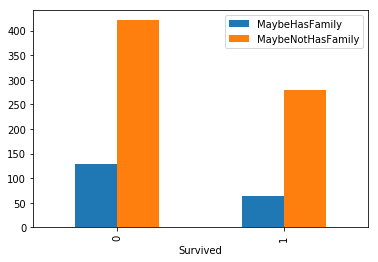

In [19]:
pd.concat([maybe_has_family, maybe_has_not_family], axis=1).plot(kind='bar')

なんか微妙だな・・・？？？  
家族持ち（仮説:　名字が同じ人は家族かも）は生存する確率は低かったかも

思ったけど、FamilySizeが1だったらダメじゃね？
それもフィルタにしないといけないかも

In [20]:
train[train['LastName'].str.contains('Navratil')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,LastName
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0,F2,S,3,Navratil
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0,F2,S,3,Navratil
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0,F2,S,3,Navratil


まだよくわかっていないが、こんな感じ

* LastNameで調べるのは多分正しい
    * FamilySizeと名字が同じ行数がほぼおなじ
    * 違う場合もある。これはノイズになりそうなので、どうにか外さないといけないと思う
    * FamilySizeとLastNameの整合性はあってそうだけど、数が足りない場合がある
        * これはなに？　テストデータに分割しているから、一緒になったらわかるやつかね？

In [21]:
# ここまでのやつをヘルパー関数に追加
train, test = feature_process_helper.family_size_int(train, test)
trian, test = feature_process_helper.add_last_name(train, test)

In [22]:
search_family_train = train.copy()
search_family_test = test.copy()

In [23]:
_test_concat = pd.concat([search_family_train, search_family_test.merge(submission_df, how='inner', on='PassengerId')], axis=0)

/Users/s.okubo/Documents/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [24]:
_list

['Allison',
 'Andersson',
 'Asplund',
 'Baclini',
 'Boulos',
 'Bourke',
 'Brown',
 'Carter',
 'Collyer',
 'Davies',
 'Elias',
 'Flynn',
 'Ford',
 'Fortune',
 'Goldsmith',
 'Goodwin',
 'Graham',
 'Gustafsson',
 'Hansen',
 'Harper',
 'Harris',
 'Hart',
 'Hickman',
 'Hoyt',
 'Jensen',
 'Johansson',
 'Johnson',
 'Jussila',
 'Kelly',
 'Laroche',
 'Lefebre',
 'Meyer',
 'Moran',
 'Navratil',
 'Newell',
 "O'Brien",
 'Olsen',
 'Palsson',
 'Panula',
 'Rice',
 'Richards',
 'Sage',
 'Skoog',
 'Smith',
 'Taussig',
 'Thayer',
 'Van Impe',
 'Vander Planke',
 'West',
 'Williams']

In [25]:
search_family_train[search_family_train['LastName'].str.contains('Allison')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,LastName
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,4,Allison
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,4,Allison
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,4,Allison


In [26]:
_test_concat[_test_concat['LastName'].str.contains('Allison')]

,Age,Cabin,Embarked,FamilySize,Fare,LastName,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
297,2.00,C22 C26,S,4,151.55,Allison,"Allison, Miss. Helen Loraine",2,298,1,female,1,0,113781
305,0.92,C22 C26,S,4,151.55,Allison,"Allison, Master. Hudson Trevor",2,306,1,male,1,1,113781
498,25.00,C22 C26,S,4,151.55,Allison,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",2,499,1,female,1,0,113781
306,30.00,C22 C26,S,4,151.55,Allison,"Allison, Mr. Hudson Joshua Creighton",2,1198,1,male,1,0,113781


名字で紐付けるのは正解っぽいです

In [27]:
# 学習させるためリセット！
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [28]:
trian, test = feature_process_helper.add_last_name(train, test)
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size', 'LastName'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

TypeError: names() missing 1 required positional argument: 'submission_df'

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])
print("%.4f" % rf.oob_score_)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [30]:
# scikit-learnでは実装されているんだって
# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [31]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [32]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

TypeError: _write() got an unexpected keyword argument 'train'

 0.79426 ....  
 クソがー！！＼（｀Д´#）ノ

In [33]:
# 流石にLastNameはやり過ぎと思うのでFamilySizeを追加
# 学習させるためリセット！
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [34]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Name_Title'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket', 'Cabin', 'SibSp', 'Parch'])

TypeError: names() missing 1 required positional argument: 'submission_df'

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])
print("%.4f" % rf.oob_score_)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

In [ ]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

0.77990  
説明変数を減らしてもダメー

### モデルを複数使ってみる

In [ ]:
from sklearn import model_selection, ensemble, svm

In [ ]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)
et_clf = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=0)
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=0)
ada_clf = ensemble.AdaBoostClassifier(n_estimators=100, random_state=0)
svm_clf = svm.LinearSVC(C=0.1,random_state=0)

In [ ]:
e_clf = ensemble.VotingClassifier(estimators=[('rf',rf_clf), ('et',et_clf), ('gbc',gb_clf), ('ada',ada_clf), ('svm',svm_clf)])

In [ ]:
# score using cross validation
clf_list = [rf_clf, et_clf, gb_clf, ada_clf, svm_clf, e_clf]
name_list = ['Random Forest', 'Extra Trees', 'Gradient Boosted', 'AdaBoost', 'Support Vector Machine', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = model_selection.cross_val_score(clf, train.iloc[:, 2:], train.iloc[:, 1], cv=10)
    print("Accuracy: %0.2f +/- %0.2f (%s 95%% CI)" % (scores.mean(), scores.std()*2, name))

In [ ]:
# fit ensemble classifier
e_clf = e_clf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
prediction = e_clf.predict(test.iloc[:, 1:])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(e_clf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

0.77990

### plotを学ぶ

In [ ]:
# 散布図行列というものがあるらしい
import matplotlib.pyplot as plt
import seaborn as sns

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species", size=2.5)
plt.show()

In [ ]:
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [ ]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [ ]:
train.columns

In [ ]:
# タイタニックのデータで試す
sns.pairplot(train[['Survived', 'Age', 'Sex_male', 'Sex_female']], hue="Survived", size=2.5)
plt.show()

In [ ]:
sns.pairplot(train[['Survived', 'Name_Len', 'Fare', 'Pclass_3', 'Pclass_2', 'Pclass_1']], hue='Survived', size=2.5)

In [ ]:
# タイタニックのデータで試す
sns.pairplot(train[['Survived', 'Embarked_S', 'Embarked_C', 'Embarked_Q']], hue='Survived', size=2.5)
plt.show()

In [ ]:
sns.pairplot(train[['Survived', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big']], hue='Survived', size=2.5)
plt.show()

In [ ]:
sns.pairplot(train[['Survived', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F']], hue='Survived', size=2.5)
plt.show()

In [ ]:
sns.pairplot(train[['Survived', 'Name_Title_Mr.', 'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.', 'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.', 'Name_Title_Col.', 'Age']], hue='Survived', size=2.5)
plt.show()

In [ ]:
plt.figure(figsize=(30, 20))
plt.rcParams["font.size"] = 18
sns.heatmap(train.corr())

In [ ]:
train['AgeClass'] = train['Age'] // 10 * 10

In [ ]:
___test = pd.concat([train, pd.get_dummies(train['AgeClass']).reset_index()], axis=1)

In [ ]:
___test.head()

In [ ]:
# 特徴量の尺度を揃える
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [ ]:
test.loc[test['Fare'].isnull() == True, 'Fare'] = 0

In [ ]:
# min-maxスケーリング
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
train.iloc[:, 2:] = mms.fit_transform(train.iloc[:, 2:])
test.iloc[:, 1:] = mms.fit_transform(test.iloc[:, 1:])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
lr_param = {
    "C": list(np.logspace(0, 4, 10))
}

In [ ]:
lr = LogisticRegression()

In [ ]:
gs = GridSearchCV(estimator=lr,
                  param_grid=lr_param,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

In [ ]:
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(gs, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test.loc[test['Fare'].isnull() == True, 'Fare'] = 0

In [ ]:
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train.iloc[:, 2:] = stdsc.fit_transform(train.iloc[:, 2:])
test.iloc[:, 1:] = stdsc.fit_transform(test.iloc[:, 1:])

In [ ]:
lr_param = {
    "C": list(np.logspace(0, 4, 10))
}
lr = LogisticRegression()
gs = GridSearchCV(estimator=lr,
                  param_grid=lr_param,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(gs, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

ちょっとあがったかな？

In [ ]:
# L1正則化による疎かな解
lr_param = {
    "C": list(np.logspace(0, 4, 10)),
    'penalty': ['l1']
}
lr = LogisticRegression()
gs = GridSearchCV(estimator=lr,
                  param_grid=lr_param,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_estimator_

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(gs, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
# KNN法を試す
from sklearn.neighbors import KNeighborsClassifier
knn_param = {
    'n_neighbors': [5, 10, 15, 20],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
gs = GridSearchCV(estimator=knn,
                  param_grid=knn_param,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_estimator_

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(gs, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
# ロジスティック回帰とKNNをアンサンブル
from sklearn.neighbors import KNeighborsClassifier
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test.loc[test['Fare'].isnull() == True, 'Fare'] = 0

# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train.iloc[:, 2:] = stdsc.fit_transform(train.iloc[:, 2:])
test.iloc[:, 1:] = stdsc.fit_transform(test.iloc[:, 1:])

lr_param = {
    "C": list(np.logspace(0, 4, 10))
}

knn_param = {
    'n_neighbors': [5, 10, 15, 20],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
lr = LogisticRegression()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import  RandomizedSearchCV

In [ ]:
params = {}
params.update({"knn__" + k: v for k, v in knn_param.items()})
params.update({"lr__" + k: v for k, v in lr_param.items()})

eclf = VotingClassifier(estimators=[("knn", knn), ("lr", lr)],voting="soft")
clf = RandomizedSearchCV(eclf,
    param_distributions=params,
    cv=5,
    n_iter=80,
    n_jobs=-1,
    verbose=2)

In [ ]:
clf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
lr_param = {
    "C": 1.0
}

knn_param = {
    'n_neighbors': 5,
    'p': 1
}
eclf = VotingClassifier(estimators=[("knn", knn), ("lr", lr)],voting="soft")
eclf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(eclf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

ちょっとはあがった？

In [ ]:
# ランダムフォレストで特徴選択する

In [ ]:
# 主成分分析してみる
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()

In [ ]:
train_pca = pca.fit_transform(train.iloc[:, 2:])
test_pca = pca.transform(test.iloc[:, 1:])

In [ ]:
lr.fit(train_pca, train.iloc[:, 1])

In [ ]:
print(lr.score(train_pca, train.iloc[:, 1]))
print(lr.score(test_pca, submission_df['Survived']))

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(lr, train_pca, train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    # 最小値, 最大値からエリアの領域を割り出す
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # resolutionの間隔で区切った領域を定義
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    # print(xx1.shape)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

In [ ]:
plot_decision_regions(train_pca, train.iloc[:, 1], classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# LDA
from sklearn.lda import LDA
lda = LDA(n_components=3)
train_lda = lda.fit_transform(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
lr = LogisticRegression()
lr.fit(train_pca, train.iloc[:, 1])

In [ ]:
print(lr.score(train_pca, train.iloc[:, 1]))
print(lr.score(test_pca, submission_df['Survived']))

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(lr, train_pca, train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
# 特徴量の尺度を揃える
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [ ]:
# パイプラインを使う
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(random_state=1))
])

In [ ]:
pipe_lr.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(pipe_lr, train_pca, train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

これは便利

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1))
])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{
    'clf__C': param_range,
    'clf__kernel': ['linear'],
    'clf__C': param_range,
    'clf__gamma': param_range,
    'clf__kernel': ['rbf']
}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

In [ ]:
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

In [ ]:
# 最適な値でやり直す
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1, C=1.0, gamma=0.01, kernel='rbf'))
])

In [ ]:
pipe_svc.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(pipe_svc, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
# pipelineを覚えたところで、knn、LR, RFを使って、Randamizeのあとにアンサンブル
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [ ]:
train.head()

In [ ]:
# ダミー変数の１つを削除する
for _data in [train, test]:
    for i in ['Cabin_num_(65.667, 148]', 'Pclass_3', 'Sex_male', 'Embarked_S', 'Cabin_Letter_n', 'Name_Title_Mr.', 'Fam_Size_Nuclear']:
        del _data[i]

In [ ]:
# パイプラインを使う
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
# svmだけRandamizeにあてるのが難しかったので別個やる
from sklearn.model_selection import GridSearchCV
pipe_svm = Pipeline([
        ('scl', StandardScaler()),
        ('svc', SVC(random_state=1))
])

svm_param = [
    {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
    {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['rbf'], 'svc__gamma': [0.001, 0.0001]},
    {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4], 'svc__gamma': [0.001, 0.0001]},
    {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['sigmoid'], 'svc__gamma': [0.001, 0.0001]}
]

gs = GridSearchCV(estimator=pipe_svm,
                   param_grid=svm_param,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)

In [ ]:
test.loc[test['Fare'].isnull() == True, 'Fare'] = 0

In [ ]:
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
# 40分ぐらい？恐ろしい...
gs.best_estimator_

In [ ]:
gs.best_params_

In [ ]:
# ロジスティック回帰
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('lr', LogisticRegression(random_state=1))
])
lr_param = [{
    "lr__C": np.logspace(0, 4, 10)
}]
gs = GridSearchCV(estimator=pipe_lr,
                   param_grid=lr_param,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_params_

In [ ]:
# ランダムフォレスト
pipe_rf = Pipeline([
        ('rf', RandomForestClassifier())
])
rf_param = [{
    "rf__n_estimators": [5, 10, 50, 100, 300],
    "rf__max_features": [3, 5, 10, 15, 20],
    "rf__min_samples_split": [3, 5, 10, 20],
    "rf__max_depth": [3, 5, 10, 20]
}]
gs = GridSearchCV(estimator=pipe_rf,
                   param_grid=rf_param,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_params_

In [ ]:
# knn
pipe_knn = Pipeline([
        ('scl', StandardScaler()),
        ('knn', KNeighborsClassifier())
])
knn_param = [{
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__p': [1, 2]
}]
gs = GridSearchCV(estimator=pipe_knn,
                   param_grid=knn_param,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_params_

In [ ]:
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('lr', LogisticRegression(C = 21.544346900318832))
])
pipe_svm = Pipeline([
        ('scl', StandardScaler()),
        ('svm', SVC(C = 100, gamma = 0.001, kernel = 'rbf', probability = True))
])
pipe_knn = Pipeline([
        ('scl', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors = 10, p = 1))
])
pipe_rf = Pipeline([
        ('rf', RandomForestClassifier(max_depth = 5, 
                                      max_features =20,
                                      min_samples_split = 5,
                                      n_estimators = 10))
])

lr_param = {
    # 'lr__scl': ['test'],
    "lr__C": list(np.logspace(0, 4, 10))
}
rf_param = {
    "rf__n_estimators": [5, 10, 50, 100, 300],
    "rf__max_features": [3, 5, 10, 15, 20],
    "rf__min_samples_split": [3, 5, 10, 20],
    "rf__max_depth": [3, 5, 10, 20]
}
knn_param = {
    'n_neighbors': [5, 10, 15, 20],
    'p': [1, 2]
}
svm_param = {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
params = {}
params.update(lr_param)
# params.update(rf_param)
# params.update({"lr__" + k: v for k, v in lr_param.items()})
# params.update({"rf__" + k: v for k, v in rf_param.items()})
# params.update({"svm__" + k: v for k, v in svm_param.items()})
# params.update({"knn__" + k: v for k, v in knn_param.items()})

In [ ]:
eclf = VotingClassifier(estimators=[('lr', pipe_lr), ('svm', pipe_svm), ('knn', pipe_knn), ('rf', pipe_rf)], voting="soft")

In [ ]:
# clf = RandomizedSearchCV(eclf,
#     param_distributions=params,
#     cv=5,
#     n_iter=5,
#     n_jobs=-1,
#     verbose=2)

In [ ]:
eclf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
test.loc[test['Fare'].isnull() == True, 'Fare'] = 0

In [ ]:
print(eclf.score(train.iloc[:, 2:], train.iloc[:, 1]))
print(eclf.score(test.iloc[:, 1:], submission_df['Survived']))

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(eclf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
write_submission._write(model=eclf, train=train, test=test, submission_df=submission_df)

* 最初: 0.79426  
* ダミー変数 - 1: 0.78947

In [ ]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1,5,10],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

In [ ]:
gs = gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_params_

In [ ]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                criterion='gini',
                                min_samples_leaf=1,
                                min_samples_split=4,
                                n_estimators=100,
                                n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

3回目: 0.78469

In [ ]:
_rf_important = a

In [ ]:
_rf_important

In [ ]:
# ランダムフォレストの結果で良い変数だけ残す
for _data in [train, test]:
    for i in ['Name_Title_Dr.',
              'Cabin_num_(65.667, 148]',
              'Pclass_2',
              'Sex_male',
              'Embarked_S',
              'Cabin_Letter_n',
              'Name_Title_Mr.',
              'Fam_Size_Nuclear',
              'Name_Title_Ms.',
              'Cabin_Letter_C',
              'Name_Title_Col.',
              'Cabin_num_[2, 28.667]',
              'Cabin_Letter_E',
              'Age_Null_Flag',
              'Cabin_Letter_D',
              'Cabin_num_(28.667, 65.667]',
              'Cabin_Letter_B',
              'Name_Title_Master.',
              'Cabin_Letter_G',
              'Cabin_Letter_F',
              'Name_Title_Rev.',
              'Cabin_Letter_A',
              'Name_Title_Mrs.',
              'Name_Title_Miss.',
              'Fam_Size_Big',
              'Fam_Size_Solo']:
        del _data[i]

In [ ]:
train.head()

In [ ]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1,5,10],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

In [ ]:
gs.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
gs.best_params_

In [ ]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                criterion='gini',
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=100,
                                n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [ ]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

In [ ]:
_rf_important = pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

In [ ]:
_rf_important

In [ ]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

下がった・・・？  
0.75120